In [ ]:
# 

In [ ]:
import pandas as pd 
import numpy as np 

import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go 

from prophet import Prophet
from prophet.diagnostics import cross_validation

DATA_PATH = 'https://github.com/fakhrirobi/ML_Pacmann_5/blob/main/final/20221119_final_data.xlsx?raw=true'

In [ ]:
## Data Preparation 

In [ ]:
da

In [ ]:
data = pd.read_excel(DATA_PATH,converters={'tanggal':np.datetime64})

In [ ]:
data = data.replace('-',np.NaN)

In [ ]:
#there are lots of missing values, those were resulted from holiday calendar such as sunday,saturday,idul fitri , etc, assumed data is the same like previous date
#the missing values imputation in this part will use pandas.backfill and pandas.ffill()
data.isnull().sum()

tanggal         0
medan         353
pekanbaru     356
batam         358
palembang     356
bandung       359
jakarta       359
yogyakarta    359
surabaya      358
balikpapan    348
makassar      359
dtype: int64

In [ ]:
#imputation 
city_columns = [x for x in data.columns if x != 'tanggal']
data[city_columns] = data[city_columns].fillna(method='ffill')
data[city_columns] = data[city_columns].fillna(method='bfill')

In [ ]:
data[city_columns] = data[city_columns].astype('float')

In [ ]:
data.dtypes

tanggal       datetime64[ns]
medan                 object
pekanbaru             object
batam                 object
palembang             object
bandung               object
jakarta               object
yogyakarta            object
surabaya              object
balikpapan           float64
makassar              object
dtype: object

In [ ]:
#Since we are predicting price difference by degree one shift 1 , we need to diff in pandas
data_diffed = data.set_index('tanggal')[city_columns].diff(1)

In [ ]:
data_diffed.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-12',
               '2022-11-13', '2022-11-14', '2022-11-15', '2022-11-16',
               '2022-11-17', '2022-11-18'],
              dtype='datetime64[ns]', name='tanggal', length=1053, freq=None)

In [ ]:
## Exploratory Data Analisis
data_diffed.loc['2020-01-04']

medan         0.0
pekanbaru     0.0
batam         0.0
palembang     0.0
bandung       0.0
jakarta       0.0
yogyakarta    0.0
surabaya      0.0
balikpapan    0.0
makassar      0.0
Name: 2020-01-04 00:00:00, dtype: float64

In [ ]:
data_diffed

,medan,pekanbaru,batam,palembang,bandung,jakarta,yogyakarta,surabaya,balikpapan,makassar
tanggal,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-16,0.0,0.0,500.0,-9450.0,-7000.0,-3000.0,-14100.0,-4750.0,-5050.0,1500.0


In [ ]:
data_diffed.loc['2020-01-02']

medan         0.0
pekanbaru     0.0
batam         0.0
palembang     0.0
bandung       0.0
jakarta       0.0
yogyakarta    0.0
surabaya      0.0
balikpapan    0.0
makassar      0.0
Name: 2020-01-02 00:00:00, dtype: float64

In [ ]:
## Exploratory Data Analysis

In [ ]:
# Trendline of Price Change Overtime 
fig = make_subplots(rows=10, cols=1)

In [ ]:
px.line(y=data_diffed['jakarta'],x=data_diffed.index)

In [ ]:
for idx,col in enumerate(city_columns) : 

  fig.add_trace(go.Scatter(y=data_diffed[f'{col}'], x=data_diffed.index,
                      mode='lines',
                      name=f'{col}'),row=idx+1,col=1)


fig.update_layout(width=1000,height=2000,margin=dict(l=0,r=0,t=0,b=0),paper_bgcolor="#ffffff",
                  title='Cabai Merah Price Change From Different Cities')

In [ ]:
# Add Decomposition Chart 

In [ ]:
#define stationarity test 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)



def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
data_diffed = data_diffed.dropna()

In [ ]:
#Stationarity using AdFuller Test 
for city in city_columns : 
  print(city)
  adf_test(data_diffed[f"{city}"])
  print("=====================================")

medan
Results of Dickey-Fuller Test:
Test Statistic                  -32.628506
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1051.000000
Critical Value (1%)              -3.436587
Critical Value (5%)              -2.864294
Critical Value (10%)             -2.568236
dtype: float64
pekanbaru
Results of Dickey-Fuller Test:
Test Statistic                -1.166885e+01
p-value                        1.855762e-21
#Lags Used                     7.000000e+00
Number of Observations Used    1.044000e+03
Critical Value (1%)           -3.436629e+00
Critical Value (5%)           -2.864312e+00
Critical Value (10%)          -2.568246e+00
dtype: float64
batam
Results of Dickey-Fuller Test:
Test Statistic                -1.132301e+01
p-value                        1.161648e-20
#Lags Used                     6.000000e+00
Number of Observations Used    1.045000e+03
Critical Value (1%)           -3.436623e+00
Critical Value (5%)       

In [ ]:
data_diffed

,medan,pekanbaru,batam,palembang,bandung,jakarta,yogyakarta,surabaya,balikpapan,makassar
tanggal,,,,,,,,,,
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-16,0.0,0.0,500.0,-9450.0,-7000.0,-3000.0,-14100.0,-4750.0,-5050.0,1500.0


In [ ]:
def pipe_parsing_data(data,city) : 
  data = data[[city]]
  data = data.reset_index()
  data = data.rename(columns={'tanggal':'ds',city:'y'}) #required by prophet 
  return data 

In [ ]:
data_diffed

,medan,pekanbaru,batam,palembang,bandung,jakarta,yogyakarta,surabaya,balikpapan,makassar
tanggal,,,,,,,,,,
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-11-16,0.0,0.0,500.0,-9450.0,-7000.0,-3000.0,-14100.0,-4750.0,-5050.0,1500.0


In [ ]:
## Prophet Modelling 
#create dictionary to store multiple trained model 
cities_dictionary = {}
for city in city_columns :
  #instanciate prophet 
  m = Prophet()

  parsed_df = data_diffed.pipe(pipe_parsing_data,city)
  print(parsed_df.columns)
  # fit the model 
  m.fit(parsed_df)
  forecast_ = m.predict(parsed_df)
  cities_dictionary[city] = [m,forecast_]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/qd374xx0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/evr8hyy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36768', 'data', 'file=/tmp/tmp63afg6tr/qd374xx0.json', 'init=/tmp/tmp63afg6tr/evr8hyy5.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_modelyladgg57/prophet_model-20221119181619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Index(['ds', 'y'], dtype='object')


18:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/lgcyrvc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/m7g4mzzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18548', 'data', 'file=/tmp/tmp63afg6tr/lgcyrvc6.json', 'init=/tmp/tmp63afg6tr/m7g4mzzj.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_modelgb4_kcgy/prophet_model-20221119181620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/uj2xe7xd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/ea6k6t83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11102', 'data', 'file=/tmp/tmp63afg6tr/uj2xe7xd.json', 'init=/tmp/tmp63afg6tr/ea6k6t83.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_model7am873lf/prophet_model-20221119181621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/hx7swvs5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/fdee9cjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19129', 'data', 'file=/tmp/tmp63afg6tr/hx7swvs5.json', 'init=/tmp/tmp63afg6tr/fdee9cjl.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_model4q1b_3jo/prophet_model-20221119181622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/q952uto1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/n8l91xph.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5408', 'data', 'file=/tmp/tmp63afg6tr/q952uto1.json', 'init=/tmp/tmp63afg6tr/n8l91xph.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_model3ajmb9g6/prophet_model-20221119181623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:23 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'y'], dtype='object')


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/mhwhkj54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/4edzu6d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65159', 'data', 'file=/tmp/tmp63afg6tr/mhwhkj54.json', 'init=/tmp/tmp63afg6tr/4edzu6d7.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_model262ddzv2/prophet_model-20221119181624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Index(['ds', 'y'], dtype='object')


18:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/0q3iabmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/j2fpm329.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52276', 'data', 'file=/tmp/tmp63afg6tr/0q3iabmp.json', 'init=/tmp/tmp63afg6tr/j2fpm329.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_model2esi01f4/prophet_model-20221119181625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Index(['ds', 'y'], dtype='object')


18:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/c_jpgne7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/kk7rd5z6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32693', 'data', 'file=/tmp/tmp63afg6tr/c_jpgne7.json', 'init=/tmp/tmp63afg6tr/kk7rd5z6.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_modelzivdupei/prophet_model-20221119181626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Index(['ds', 'y'], dtype='object')


18:16:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/xogv_y0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/gcd4tlzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29870', 'data', 'file=/tmp/tmp63afg6tr/xogv_y0c.json', 'init=/tmp/tmp63afg6tr/gcd4tlzx.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_model7xrqng6n/prophet_model-20221119181627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Index(['ds', 'y'], dtype='object')


18:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/tyy06f7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/ef9o4860.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58027', 'data', 'file=/tmp/tmp63afg6tr/tyy06f7n.json', 'init=/tmp/tmp63afg6tr/ef9o4860.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_modelako5w0sg/prophet_model-20221119181628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:16:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:16:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Index(['ds', 'y'], dtype='object')


In [ ]:
cities_dictionary

{'medan': [<prophet.forecaster.Prophet at 0x7fec6ef81450>,
               ds      trend   yhat_lower   yhat_upper  trend_lower  \
  0    2020-01-02  31.525240 -3510.352240  3155.270677    31.525240   
  1    2020-01-03  31.481544 -3550.638378  3611.913987    31.481544   
  2    2020-01-04  31.437849 -3566.748054  3356.948735    31.437849   
  3    2020-01-05  31.394153 -3523.545331  3569.405457    31.394153   
  4    2020-01-06  31.350458 -3454.517650  3272.095802    31.350458   
  ...         ...        ...          ...          ...          ...   
  1047 2022-11-14 -46.892058 -3585.653816  3116.266427   -46.892058   
  1048 2022-11-15 -47.067769 -3496.192062  3264.643671   -47.067769   
  1049 2022-11-16 -47.243480 -3248.281504  3614.553607   -47.243480   
  1050 2022-11-17 -47.419191 -3822.740570  3242.030680   -47.419191   
  1051 2022-11-18 -47.594902 -3493.482185  3434.074876   -47.594902   
  
        trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
  0

In [ ]:
df_cv = cross_validation(cities_dictionary['medan'], period='30 days', horizon = '180 days')


INFO:prophet:Making 12 forecasts with cutoffs between 2021-06-26 00:00:00 and 2022-05-22 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/9813vkrw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/7dmzbvo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7896', 'data', 'file=/tmp/tmp63afg6tr/9813vkrw.json', 'init=/tmp/tmp63afg6tr/7dmzbvo0.json', 'output', 'file=/tmp/tmp63afg6tr/prophet_modeli89d_jpb/prophet_model-20221119180706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/o4650ped.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp63afg6tr/2ew830ei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

In [ ]:
print('MAPE',mean_absolute_percentage_error(df_cv['y'],df_cv['yhat']))
print('MAE',mean_absolute_error(df_cv['y'],df_cv['yhat']))
print('MAE',mean_squared_error(df_cv['y'],df_cv['yhat']))

MAPE 1.0327975508442715e+18
MAE 1108.3593829068056
MAE 12701421.277569449


In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,18 days,6.914391e+06,2629.522938,1020.520719,inf,1.988515,0.888889
1,19 days,6.460180e+06,2541.688371,994.071825,inf,1.988515,0.888889
2,20 days,6.320464e+06,2514.053373,964.039092,inf,1.991155,0.898148
3,21 days,6.781587e+06,2604.147951,988.055825,inf,1.991420,0.898148
4,22 days,6.782038e+06,2604.234658,989.039539,inf,1.991420,0.898148


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



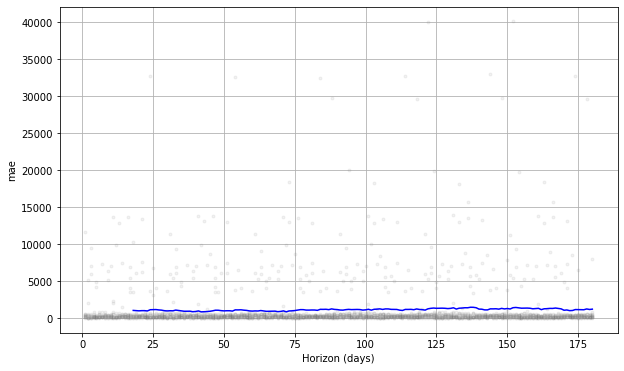

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')
